In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [17]:
fs = 15
resol = 0.0759

wsrc = '../hpcc/clean/'
tsrc = '../hpcc/watershed/'
rsrc = '../hpcc/rotated/'
dst = '../hpcc/traditional/'

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)
struc3 = ndimage.generate_binary_structure(3, 3)

ssrange = [75,175,200,250,300,-50]

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]
Sxyz = Sx + Sy + Sz
fs = 15

In [3]:
idname = '2012SB'

rownum = 12
treenum = 57
nutnum = 3

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

2012SB_R12_T57
../hpcc/traditional/2012SB_R12_T57/


In [4]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
mxval = 2**(8*img.itemsize)-1
tissuefiles = sorted(glob.glob(tsrc + bname + '/' + fname + '_*.tif'))

if True:
    air  = tf.imread(tissuefiles[0])
    meat = tf.imread(tissuefiles[1])
    shell= tf.imread(tissuefiles[2])
    vein = tf.imread(tissuefiles[3])

mxval = 2**(8*img.itemsize)

2012SB_R12_T57_003


In [5]:
PAD = 20

dshell = np.pad(shell, PAD)
dshell = ndimage.binary_dilation(dshell, struc2, PAD-2, border_value=0)

eshell = ndimage.binary_erosion(dshell, struc2, PAD-2, border_value=1)
eshell = eshell[PAD:-PAD, PAD:-PAD, PAD:-PAD]
fshell = wnut.fill_component(eshell)

Closed X
Closed Y
Closed Z


In [6]:
N = 15
bulk = ndimage.binary_erosion(eshell, struc1, N, border_value=1)
cbulk = wnut.get_largest_element(bulk, 1e-2)
dbulk = ndimage.binary_dilation(cbulk, struc1, N-8, border_value=0)

298 components	 3 preserved
[204047 144984   4409    148     78     33     17     12     10      9
      5      3      2      2      2      2      2      1      1      1]


In [7]:
foo = eshell.copy()
foo[shell > 0] = 0
bar = ndimage.binary_erosion(foo, struc1, 3, border_value=1)
#bar = ndimage.binary_dilation(bar, struc1, 3, border_value=0)

In [8]:
dbar = wnut.get_largest_element(bar)

474 components	 1 preserved
[367131  27962   8172   4494   2151   1623   1178    922    674    637
    582    560    511    371    327    269    251    218    168    132]


In [9]:
cavity = (~eshell & fshell) | bar

In [10]:
fill = wnut.fill_component(cavity)

Closed X
Closed Y
Closed Z


In [11]:
N = 8
cfill = ndimage.binary_erosion(fill, struc1, N, border_value=1)
cfill = ndimage.binary_dilation(cfill, struc1, N, border_value=0)

In [12]:
ishell = shell*cfill
ishell = wnut.get_largest_element(ishell, 1e-2)

36 components	 9 preserved
[12220  5478  4710  4149  2329   896   489   378   365   320   152   145
   141    75    67    61    59    10    10     9]


In [13]:
mask = ndimage.binary_dilation(ishell, struc1, 20, border_value=0)
interior = shell*mask

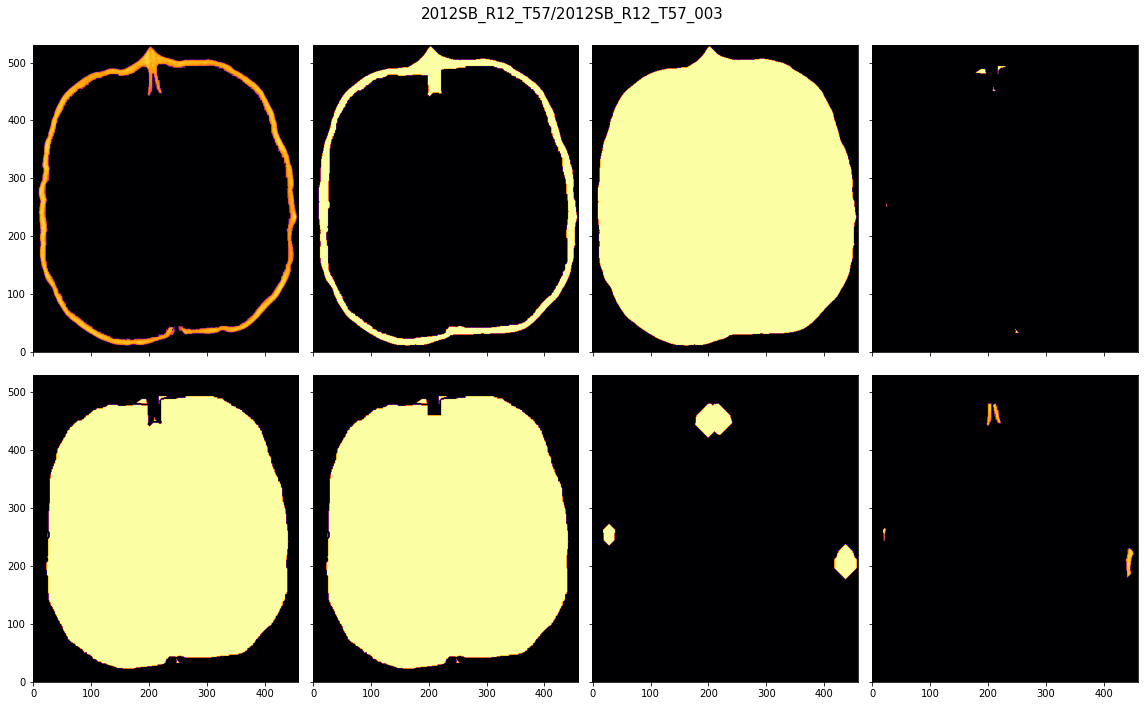

In [24]:
k = 200
ss = np.s_[:,:,k]
#ss = np.s_[:,k,:]
#ss = np.s_[k,:,:]

fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()
i = 0
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(eshell[ss], cmap='inferno', origin='lower')
i = 2
ax[i].imshow(fshell[ss], cmap='inferno', origin='lower')
i = 3
ax[i].imshow(bar[ss], cmap='inferno', origin='lower')
i = 4
ax[i].imshow(cavity[ss], cmap='inferno', origin='lower')
i = 5
ax[i].imshow(fill[ss], cmap='inferno', origin='lower')
i = 6
ax[i].imshow(mask[ss], cmap='inferno', origin='lower')
i = 7
ax[i].imshow(interior[ss], cmap='inferno', origin='lower')

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

In [19]:
test = np.zeros_like(img)
test[shell > 0] += 5
test[interior > 0 ] += 2

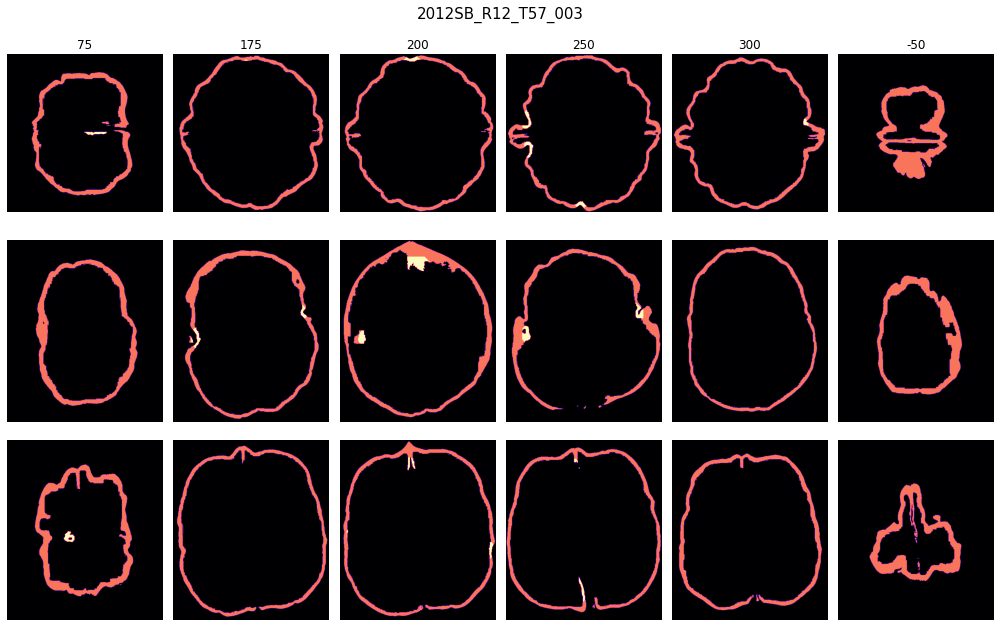

In [23]:
fig, ax = plt.subplots(3,len(ssrange),figsize=(14,9), sharex=False, sharey=False)
for i in range(3):
    for j in range(len(ssrange)):
        ss = Sxyz[len(ssrange)*i + j]
        ax[i,j].imshow(test[ss], cmap='magma', origin='lower', vmax=7)
        ax[i,j].axis('off')
for j in range(len(ssrange)):
    ax[0,j].set_title(ssrange[j])
fig.suptitle(fname, fontsize=fs, color='black');
fig.tight_layout()

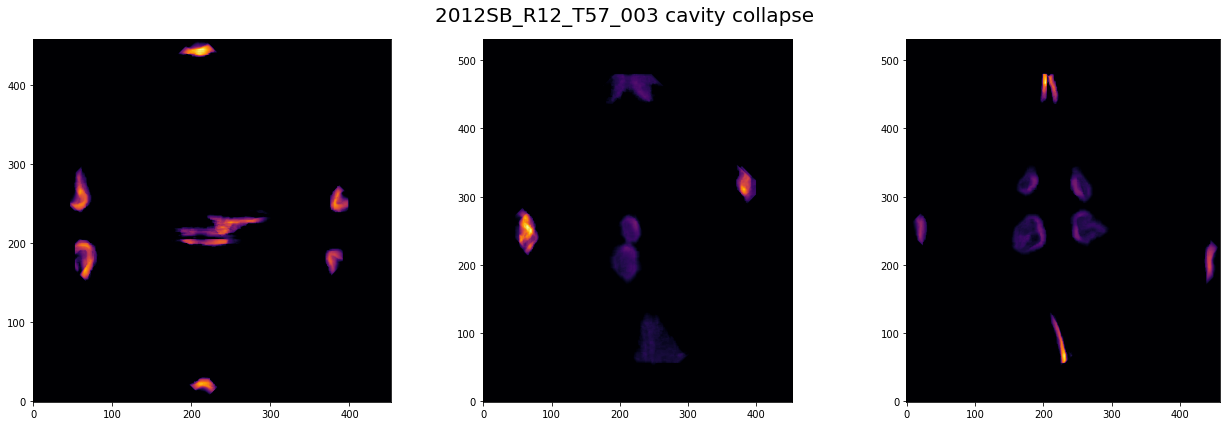

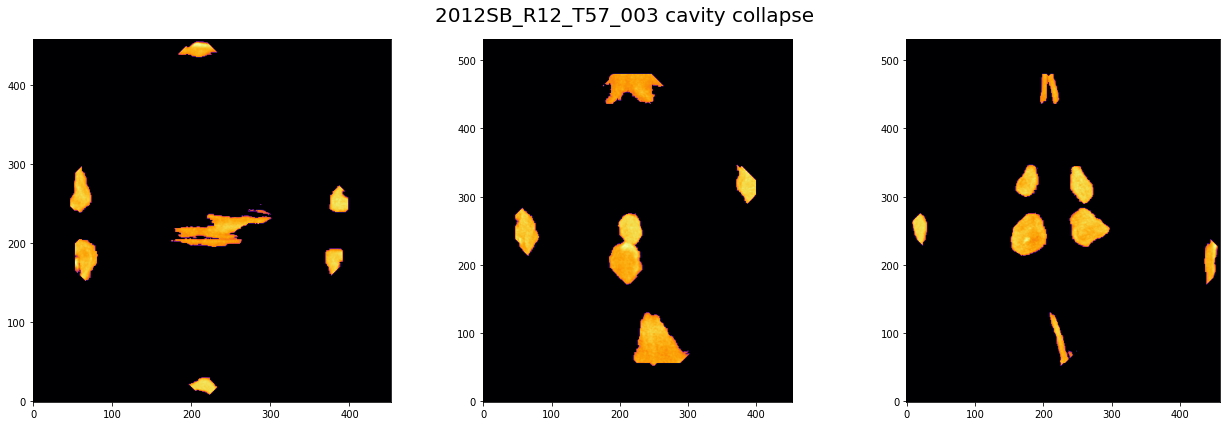

In [15]:
snaps = wnut.collapse_dimensions(interior)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)

snaps = wnut.collapse_dimensions_max(interior)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)

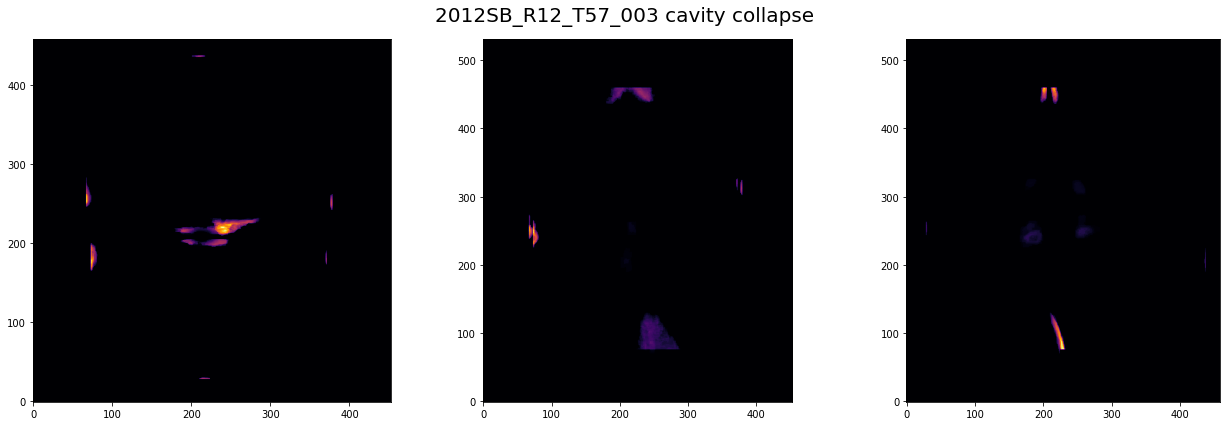

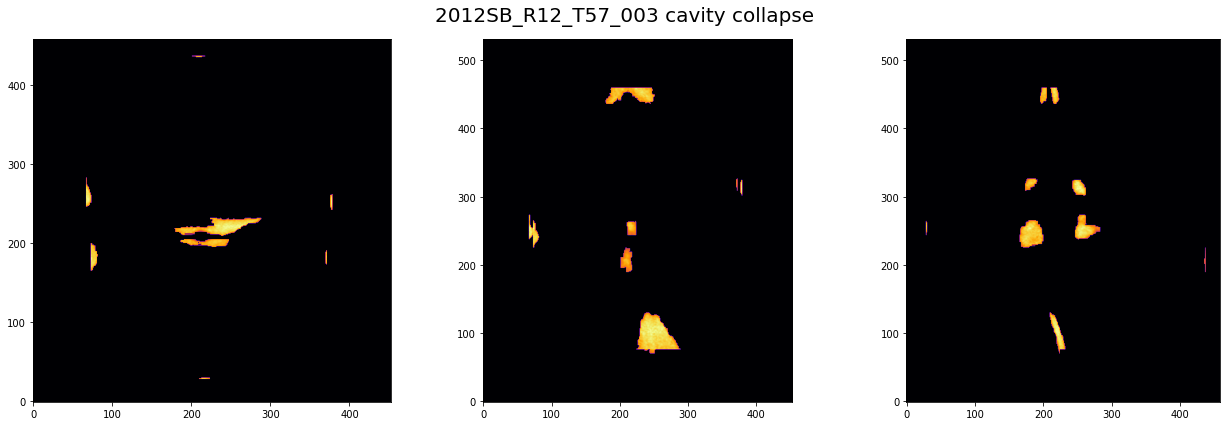

In [16]:
snaps = wnut.collapse_dimensions(ishell)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)

snaps = wnut.collapse_dimensions_max(ishell)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)